In [1]:
import numpy as np
import tifffile as tiff
import pandas as pd
from skimage import measure
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import scimap as sm
import squidpy as sq
import scanpy as sc
import anndata as ad

C:\Users\diaak\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Running SCIMAP  2.1.3


We load the images and their corresponding masks. We then create a function called extract_cell_features() to extract cell features and markers. Markers identified from qupath and mapped to image channels. Cells with a surface area of less than 50 or more than 500 are considered artifacts and are removed.

In [40]:
# File paths for both models
image_a1_path = 'A-1.tif'  # Chemin pour A1 (Eµ-Myc)
mask_a1_path = 'A-1_cell_mask.ome.tiff'  # Mask for A1
image_a2_path = 'A-2.tif'  # Path for A2 (A20)
mask_a2_path = 'A-2_cell_mask.ome.tiff'  # Mask for A2

# Load images and masks
image_a1 = tiff.imread(image_a1_path)
mask_a1 = tiff.imread(mask_a1_path)
image_a2 = tiff.imread(image_a2_path)
mask_a2 = tiff.imread(mask_a2_path)

cell_data = []
# List of biological marker names corresponding to the 17 channels
markers = [
    'DAPI', 'CD4', 'c-Myc', 'CD11b', 'CD8', 'Melan-A', 'CD11c', 'aSMA',
    'FoxP3', 'CD19', 'CD3', 'MPO', 'F4/80', 'Ki67', 'CD31', 'CD45', 'Na/K ATPase'
]

def extract_cell_features(image, labeled_mask, model_name):
    """Fonction pour extraire les caractéristiques des cellules avec des mesures géométriques supplémentaires"""
    for region in measure.regionprops(labeled_mask):
        # Filter small and large cells
        if 50 <= region.area <= 500:
            cell_features = {
                'label': region.label,
                'area': region.area,
                'model': model_name,
                'X_centroid': region.centroid[1],  # Centroid X coordinate
                'Y_centroid': region.centroid[0],  # Y coordinate of centroid
                'MajorAxisLength': region.major_axis_length,  # Length of main axis
                'MinorAxisLength': region.minor_axis_length,  # Length of minor axis
                'Eccentricity': region.eccentricity,  # Eccentricity
                'Solidity': region.solidity,  # Solidity
                'Extent': region.extent,  # Scope (area / bounding box area)
                'Orientation': region.orientation  # Cell orientation
            }
            # Extract average intensities for each channel with specific markers
            for channel in range(image.shape[0]):  # 17 channels
                intensity = np.mean(image[channel, region.coords[:, 0], region.coords[:, 1]])
                cell_features[markers[channel]] = intensity
            cell_data.append(cell_features)
            
# Extract features for both models
extract_cell_features(image_a1, mask_a1, 'Eµ-Myc')
extract_cell_features(image_a2, mask_a2, 'A20')

# Converting data into DataFrame
df = pd.DataFrame(cell_data)
df.head()

,label,area,model,X_centroid,Y_centroid,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,...,aSMA,FoxP3,CD19,CD3,MPO,F4/80,Ki67,CD31,CD45,Na/K ATPase
0,2,147.0,Eµ-Myc,675.346939,4.482993,27.110211,6.948095,0.966600,0.907407,0.513986,...,0.183673,0.142857,0.000000,0.108844,0.081633,0.000000,0.401361,0.244898,0.408163,0.510204
1,6,262.0,Eµ-Myc,1448.438931,205.259542,23.919689,14.139745,0.806573,0.949275,0.779762,...,16.667939,0.362595,23.938931,0.538168,2.290076,0.053435,56.641221,1.267176,11.362595,22.469466
2,7,235.0,Eµ-Myc,1469.693617,204.642553,18.471345,16.512387,0.448175,0.932540,0.652778,...,7.221277,0.246809,23.919149,0.378723,1.714894,0.055319,51.434043,1.174468,11.868085,23.612766
3,8,265.0,Eµ-Myc,1500.716981,207.550943,21.150998,16.191044,0.643438,0.929825,0.697368,...,7.732075,0.316981,23.607547,0.441509,2.098113,0.041509,37.754717,1.437736,14.901887,23.290566
4,9,230.0,Eµ-Myc,1564.543478,210.526087,20.952890,14.039557,0.742313,0.966387,0.821429,...,38.104348,0.426087,36.700000,0.721739,2.730435,0.256522,12.608696,1.565217,24.217391,42.873913


We select the relevant markers by removing the DAPI and then create an anndata object to use the scimap, squidpy and scanpy packages.

In [41]:
# Rename column
df['CellID'] = df.index
df = df.rename(columns={'area': 'Area'})
ordered_columns = [
    'CellID', 'CD4', 'c-Myc', 'CD11b', 'CD8', 'Melan-A', 'CD11c', 'aSMA',
    'FoxP3', 'CD19', 'CD3', 'MPO', 'F4/80', 'Ki67', 'CD31', 'CD45', 'Na/K ATPase',
    'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength',
    'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'model']
# Rearranging DataFrame columns
df = df[ordered_columns]
df.to_csv('image.csv', index=False) 
feature_table_path = ['image.csv']
# create the annData object
adata = sm.pp.mcmicro_to_scimap(feature_table_path, log=False)
# Save the results
adata.write('adata.h5ad')

Loading image.csv


In [4]:
adata = ad.read_h5ad('adata.h5ad')

We use the anndata object created for clustering. First we perform dimensionality reduction with UMAP and clustering with the Leiden algorithm.

In [42]:
# Dimensionality reduction and clustering
# UMAP for dimension reduction and KNN for clustering
sc.pp.neighbors(adata, n_neighbors=50, use_rep="X")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)  # Clustering with the Leiden algorithm
adata.obs['phenotype'] = adata.obs['leiden']  # Assigning clusters to phenotypes

We calculate the average marker expression (mean_intensity) by cell type. This operation will later enable us to make the manual annotation

In [43]:
# List of markers to be analyzed
markers = ['CD4', 'c-Myc', 'CD11b', 'CD8', 'Melan-A', 'CD11c', 'aSMA',
    'FoxP3', 'CD19', 'CD3', 'MPO', 'F4/80', 'Ki67', 'CD31', 'CD45', 'Na/K ATPase']  # Liste des marqueurs d'intérêt

# Retrieve marker indices from adata.var_names
marker_indices = [adata.var_names.get_loc(marker) for marker in markers]

# Extract marker data of interest from adata.X
marker_data = adata.X[:, marker_indices]

# Convert to DataFrame for easier handling
df_marker_data = pd.DataFrame(marker_data, columns=markers, index=adata.obs['phenotype'])

# Average marker intensities per phenotype (or cluster)
mean_intensity = df_marker_data.groupby(df_marker_data.index).mean()

# Show results
mean_intensity

C:\Users\diaak\AppData\Local\Temp\ipykernel_34848\982196394.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,CD4,c-Myc,CD11b,CD8,Melan-A,CD11c,aSMA,FoxP3,CD19,CD3,MPO,F4/80,Ki67,CD31,CD45,Na/K ATPase
phenotype,,,,,,,,,,,,,,,,
0,2.209140,0.930463,25.481993,3.345445,0.018769,3.906589,7.184012,0.467110,38.277936,6.163995,6.800962,0.908881,39.822067,3.361965,73.488854,57.388902
1,3.128198,3.368902,30.818955,3.046899,0.014533,3.353879,12.880375,0.696586,55.307098,7.006390,5.758348,0.591034,105.576857,4.986214,50.951414,80.292325
2,3.082853,1.839083,25.269587,2.215840,0.014711,2.417674,61.711489,0.602411,41.731167,4.558422,4.494323,1.066341,60.610401,6.588585,34.086924,61.314380
3,2.330858,2.374870,26.465551,1.900436,0.014180,2.370972,8.093431,0.610965,49.147590,3.238277,4.736786,0.657683,76.881091,4.313411,35.622702,69.174978
4,1.283503,2.520881,22.911863,1.342029,0.010294,2.047906,7.096680,0.599789,46.942455,2.353821,4.621553,0.434845,107.805639,4.006713,28.267650,56.547460
5,1.982078,0.610648,25.739615,5.626965,0.005386,7.762239,9.196963,0.410792,36.214514,11.901440,6.669443,0.901460,7.734522,4.748059,135.056923,58.326806
6,2.400689,0.441892,23.818107,3.313514,0.015447,4.542191,12.374210,0.383552,22.843234,5.646035,5.190069,1.070911,10.789402,4.640253,55.948153,47.387534
7,4.186213,0.648040,23.259395,14.131159,0.006226,5.218844,8.863356,1.241692,24.369332,51.479829,5.496390,1.048280,26.063846,4.154395,141.412393,68.892683
8,1.645764,1.414062,18.966254,1.179574,0.007448,1.442919,7.617394,0.557547,38.263846,2.329648,3.879843,0.560350,60.502915,4.765726,27.504373,46.388129


We create a new mean_intensity_standardized dataframe containing the normalized data we'll use to manually annotate the phenotypes.

In [44]:
scaler = StandardScaler()
mean_intensity_standardized = pd.DataFrame(scaler.fit_transform(mean_intensity), columns=mean_intensity.columns)
mean_intensity_standardized.index = mean_intensity.index
mean_intensity_standardized

,CD4,c-Myc,CD11b,CD8,Melan-A,CD11c,aSMA,FoxP3,CD19,CD3,MPO,F4/80,Ki67,CD31,CD45,Na/K ATPase
phenotype,,,,,,,,,,,,,,,,
0,-0.438104,-0.854563,-0.224234,-0.250094,0.410042,0.119202,-0.661804,-0.692598,-0.218550,-0.379670,-0.187484,-0.255145,-0.474961,-1.722633,0.277183,-0.469021
1,0.121020,1.953401,0.251306,-0.324708,-0.025351,-0.193120,-0.280539,0.020926,1.641236,-0.325906,-0.259679,-0.421975,1.528203,0.269948,-0.319678,1.825673
2,0.093433,0.191750,-0.243160,-0.532410,-0.006983,-0.722143,2.987796,-0.271898,0.158584,-0.482143,-0.347204,-0.172498,0.158338,2.235690,-0.766302,-0.075727
3,-0.364054,0.808731,-0.136596,-0.611237,-0.061596,-0.748533,-0.600936,-0.245300,0.968545,-0.566399,-0.330415,-0.386993,0.654011,-0.555427,-0.725630,0.711826
4,-1.001229,0.976870,-0.453241,-0.750797,-0.460887,-0.931089,-0.667649,-0.280051,0.727718,-0.622848,-0.338394,-0.503956,1.596101,-0.931674,-0.920414,-0.553325
5,-0.576240,-1.222842,-0.201279,0.320115,-0.965262,2.297923,-0.527075,-0.867710,-0.443900,-0.013487,-0.196591,-0.259040,-1.452481,-0.022213,1.907695,-0.375052
6,-0.321571,-1.417172,-0.372492,-0.258074,0.068588,0.478363,-0.314417,-0.952409,-1.904202,-0.412728,-0.299028,-0.170099,-1.359417,-0.154466,-0.187349,-1.471058
7,0.764679,-1.179784,-0.422275,2.445525,-0.878972,0.860721,-0.549403,1.715854,-1.737534,2.512540,-0.277817,-0.181978,-0.894094,-0.750503,2.076008,0.683543
8,-0.780842,-0.297678,-0.804807,-0.791399,-0.753359,-1.272950,-0.632797,-0.411396,-0.220089,-0.624391,-0.389753,-0.438081,0.155063,-0.000540,-0.940628,-1.571188


We use the cellmarker tool available on http://bio-bigdata.hrbmu.edu.cn/CellMarker/ to annotate phenotypes based on marker expression.

In [45]:
def classify_cluster(row):
    if row['CD11c'] > 2:  # Dendritic cells (DC)
        return 'DC'
    elif row['CD31'] > 0 and row['aSMA'] < 0:  # Endothelial cells (Endo)
        return 'Endo'
    elif row['CD31'] > 1 and row['aSMA'] >= 1:  # Endothelial fibroblasts (EndoFib)
        return 'EndoFib'
    elif row['CD4'] > 0 and row['FoxP3'] < 0:  # CD4+ T cells
        return 'CD4'
    elif row['CD8'] > 2:  # CD8+ T cells
        return 'CD8'
    elif row['CD3'] > 0:  # General T cells
        return 'T Cell'
    elif row['F4/80'] > 0 and row['CD11b'] > 0:  #Macrophages
        return 'Mac'
    elif row['FoxP3'] > 0 and row['CD4'] > 0:  # Regulatory T cells (Treg)
        return 'Treg'
    elif row['Ki67'] > 1.55 :  # Tumor cells
        return 'Tumour'
    elif row['MPO'] > 0:  # Neutrophils
        return 'Neut'
    elif row['aSMA'] > 0:  # Fibroblasts
        return 'Fib'
    else:
        return 'Unknown'

# Apply the classification function to each row of the DataFrame
mean_intensity_standardized['cell_type'] = mean_intensity_standardized.apply(classify_cluster, axis=1)
mean_intensity_standardized['cell_type']

phenotype
0     Unknown
1        Endo
2     EndoFib
3     Unknown
4      Tumour
5          DC
6     Unknown
7         CD8
8     Unknown
9      T Cell
10        Fib
11        CD4
Name: cell_type, dtype: object

By analyzing marker expression ans using cellMarker, phenotypes 0, 3, 6 and 8 are assigned to B Cell, Dend Cell and Tumour cell types.

In [46]:
# Replace "Unknown" on index line 3 with "B Cell".
mean_intensity_standardized.loc['3', 'cell_type'] = 'B Cell'

# Replace "Unknown" on index line 6 with "Dend Cell" 0 and 8 with tumour
mean_intensity_standardized.loc['6', 'cell_type'] = 'Dend Cell'
mean_intensity_standardized.loc['0', 'cell_type'] = 'Tumour'
mean_intensity_standardized.loc['8', 'cell_type'] = 'Tumour'

New phenotypes are assigned to object anndata

In [47]:
rename_dict = {
               'Endo': ['1'],
               'EndoFib': ['2'],
               'B Cell': ['3'],
               'Tumour': ['4', '0','8'],
                'DC': ['5'],
               'Dend Cell': ['6'],
               'CD8': ['7'],
               'T Cell': ['9'],
               'Fib': ['10'],
               'CD4': ['11']
              }

adata = sm.hl.rename(adata, rename=rename_dict, from_column='leiden', to_column='leiden_phenotype')
# Save the results
adata.write('adata_phenotype.h5ad')

Renaming 1 to Endo
Renaming 2 to EndoFib
Renaming 3 to B Cell
Renaming 4 to Tumour
Renaming 0 to Tumour
Renaming 8 to Tumour
Renaming 5 to DC
Renaming 6 to Dend Cell
Renaming 7 to CD8
Renaming 9 to T Cell
Renaming 10 to Fib
Renaming 11 to CD4


We calculate the normalized MFI for all cells

In [48]:
mean_intensity['cell_type'] = mean_intensity_standardized['cell_type'] 
mean_intensity = mean_intensity.groupby('cell_type').mean()
# Calculate the average MFI for all cells, by marker
mean_mfi_all_cells = mean_intensity[markers].mean()

# Normalize the MFI of each cell by dividing by the mean MFI of all cells.
for marker in markers:
    mean_intensity[marker] = mean_intensity[marker] / mean_mfi_all_cells[marker]

# Display the first lines of the DataFrame to check
mean_intensity.head()

,CD4,c-Myc,CD11b,CD8,Melan-A,CD11c,aSMA,FoxP3,CD19,CD3,MPO,F4/80,Ki67,CD31,CD45,Na/K ATPase
cell_type,,,,,,,,,,,,,,,,
B Cell,0.734692,1.411329,0.909232,0.393937,0.926729,0.601524,0.425381,0.849116,1.225545,0.234451,0.455893,0.425123,1.461059,0.878417,0.531606,1.084316
CD4,1.019888,0.916375,2.205295,0.608294,2.898748,1.451959,0.976247,0.846629,0.947889,0.472205,5.517079,4.954893,0.756318,1.110906,0.945394,0.979099
CD8,1.319504,0.385115,0.799083,2.929219,0.406890,1.324040,0.465848,1.725697,0.607674,3.727142,0.529001,0.677602,0.495321,0.846033,2.110332,1.079891
DC,0.624755,0.362894,0.884292,1.166402,0.352011,1.969309,0.483382,0.570916,0.903046,0.861665,0.641901,0.582699,0.146988,0.966932,2.015488,0.914271
Dend Cell,0.756703,0.262606,0.818278,0.686851,1.009523,1.152371,0.650374,0.533058,0.569619,0.408773,0.499519,0.692231,0.205043,0.944977,0.834928,0.742798


## Figure 4C: Heatmap showing the normalized cellular mean intensity of markers within the PhenoCycler staining panel, in different phenotypes of cells in A20 and Eµ-Myc tumours.

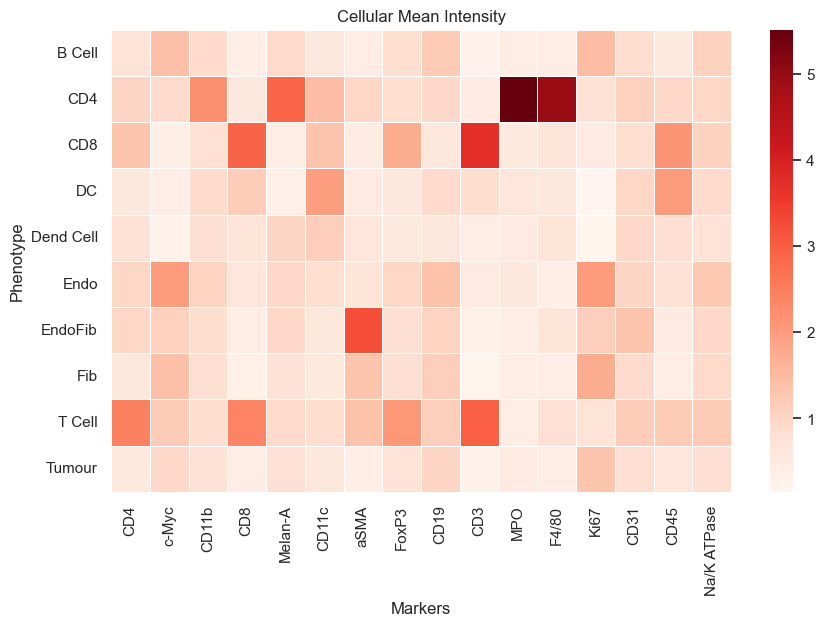

In [49]:
# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(mean_intensity, cmap="Reds", linewidths=0.5, annot=False)
markers = [ 'CD4', 'CD8', 'CD11c', 'aSMA',
    'FoxP3', 'CD19', 'CD3', 'MPO', 'F4/80', 'Ki67', 'CD31']
# Ajouter des labels et un titre
plt.title('Cellular Mean Intensity')
plt.ylabel('Phenotype')
plt.xlabel('Markers')

# Display heatmap
plt.show()


We separate the two models A20 and EuMyc to prepare the figure 4E and 4F.

In [50]:
modelA20 = adata.obs[adata.obs['model'] == 'A20']
print('Model A20', '\n \n', modelA20['leiden_phenotype'].value_counts(), '\n')
modelEuMyc = adata.obs[adata.obs['model'] == 'Eµ-Myc']
print('Model Eµ-Myc', '\n \n', modelEuMyc['leiden_phenotype'].value_counts(), '\n')

Model A20 
 
 leiden_phenotype
Tumour       4425
DC           3519
CD8          3106
Dend Cell    2795
EndoFib       102
T Cell         55
CD4            27
B Cell         19
Endo           16
Fib             3
Name: count, dtype: int64 

Model Eµ-Myc 
 
 leiden_phenotype
Tumour       7336
Endo         4442
B Cell       4353
EndoFib      4302
T Cell       1678
Fib          1618
Dend Cell     547
CD4           130
CD8            68
DC             27
Name: count, dtype: int64 



We transform modelA20 and modelEuMyc into a dataframe to calculate the proportion of cells.

In [51]:
modelA20 = modelA20['leiden_phenotype'].value_counts()
modelA20 = modelA20.to_frame(name='phenotype')
modelEuMyc = modelEuMyc['leiden_phenotype'].value_counts()
modelEuMyc = modelEuMyc.to_frame(name='phenotype')

We calculate the proportion of cells of each cell type for A20 and EuMyc. Very low cell proportions, e.g. 0.001, are ignored in the graph.

In [52]:
cell_proportions = modelA20['phenotype'].div(modelA20['phenotype'].sum(), axis=0)
cell_proportions = cell_proportions.to_frame(name='phenotype')
cell_proportions = cell_proportions.loc[['Tumour', 'DC', 'CD8', 'Dend Cell']]  
cell_proportions.reset_index(inplace=True)
print('Cell Proportion A20', '\n \n', cell_proportions, '\n')

cell_proportionsEuMyc = modelEuMyc['phenotype'].div(modelEuMyc['phenotype'].sum(), axis=0)
cell_proportionsEuMyc = cell_proportionsEuMyc.to_frame(name='phenotype')
cell_proportionsEuMyc = cell_proportionsEuMyc.loc[['Tumour', 'Endo', 'B Cell', 'EndoFib', 'T Cell', 'Fib', 'Dend Cell']]  
cell_proportionsEuMyc.reset_index(inplace=True)
print('Cell Proportion EuMyc', '\n \n', cell_proportionsEuMyc)

Cell Proportion A20 
 
   leiden_phenotype  phenotype
0           Tumour   0.314566
1               DC   0.250160
2              CD8   0.220800
3        Dend Cell   0.198692 

Cell Proportion EuMyc 
 
   leiden_phenotype  phenotype
0           Tumour   0.299416
1             Endo   0.181299
2           B Cell   0.177666
3          EndoFib   0.175585
4           T Cell   0.068487
5              Fib   0.066038
6        Dend Cell   0.022326


Cells are affected in three categories: immune, stromal and tumour.

In [53]:
# Added categorization (immune, stromal, tumour)
category_map = {
    'DC': 'immune cell',
    'CD8': 'immune cell',
    'Dend Cell': 'immune cell',
    'T Cell': 'immune cell',
    'CD4': 'immune cell',
    'B Cell': 'immune cell',
    'EndoFib': 'stromal cell',
    'Endo': 'stromal cell',
    'Fib': 'stromal cell',
    'Tumour': 'tumour'
}

# Add the 'category' column to the DataFrame
modelA20['category'] = modelA20.index.map(category_map)

# Group by category to obtain totals for cells in each category
category_totals = modelA20.groupby('category')['phenotype'].sum()
category_totals = category_totals.to_frame(name='phenotype')
print('Category total A20', '\n \n', category_totals, '\n')

# Add the 'category' column to the DataFrame
modelEuMyc['category'] = modelEuMyc.index.map(category_map)

# Group by category to obtain totals for cells in each category
category_totalsEuMyc = modelEuMyc.groupby('category')['phenotype'].sum()
category_totalsEuMyc = category_totalsEuMyc.to_frame(name='phenotype')
print('Category total EuMyc', '\n \n', category_totalsEuMyc)

Category total A20 
 
               phenotype
category               
immune cell        9521
stromal cell        121
tumour             4425 

Category total EuMyc 
 
               phenotype
category               
immune cell        6803
stromal cell      10362
tumour             7336


Proportion calculated by category (immune, stromal and tumour)

In [54]:
category_proportions = category_totals['phenotype'].div(category_totals['phenotype'].sum(), axis=0)
category_proportions = category_proportions.to_frame(name='phenotype')
category_proportions.reset_index(inplace=True)
print('Category proportions A20', '\n \n', category_proportions, '\n')

category_proportionsEuMyc = category_totalsEuMyc['phenotype'].div(category_totalsEuMyc['phenotype'].sum(), axis=0)
category_proportionsEuMyc = category_proportionsEuMyc.to_frame(name='phenotype')
category_proportionsEuMyc.reset_index(inplace=True)
print('Category proportion EuMyc', '\n \n', category_proportionsEuMyc)

Category proportions A20 
 
        category  phenotype
0   immune cell   0.676832
1  stromal cell   0.008602
2        tumour   0.314566 

Category proportion EuMyc 
 
        category  phenotype
0   immune cell   0.277662
1  stromal cell   0.422922
2        tumour   0.299416


## Figure 4E: Proportions of different cell types in A20 tumour-bearing liver

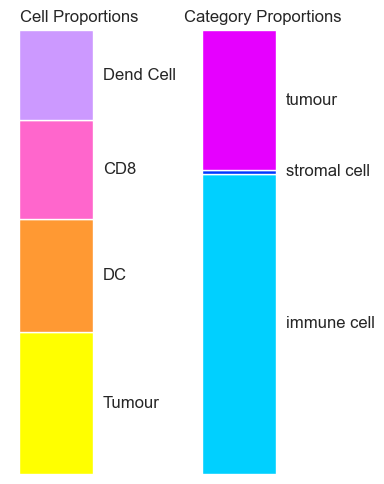

In [55]:
# Create colors for each cell type
colors = ['#FFFF00', '#FF9933', '#FF66CC', '#CC99FF']
colors2 = ['#00d0ff', '#0037ff','#e600ff']

# Creation of a stacked bar chart, with two axes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 5), gridspec_kw={'width_ratios': [1, 1]})

# Chart 1 - cell_proportions
bottom = 0
for i, row in cell_proportions.iterrows():
    ax1.bar(0, row['phenotype'], bottom=bottom, color=colors[i], label=row['leiden_phenotype'])
    bottom += row['phenotype']

# Add cell labels on the right
y_pos = cell_proportions['phenotype'].cumsum() - (cell_proportions['phenotype'] / 2)
for i, cell_type in enumerate(cell_proportions['leiden_phenotype']):
    ax1.text(0.5, y_pos[i], cell_type, va='center', ha='left')
# Add a title to the first graph
ax1.set_title('Cell Proportions')
# Customizing axes for graph 1
ax1.set_xlim([-0.5, 1])
ax1.set_ylim([0, cell_proportions['phenotype'].sum()])
ax1.set_xticks([])
ax1.set_yticks([])

# Axis removal
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Graph 2 - category_proportions
bottom = 0  # Reset bottom variable
for i, row in category_proportions.iterrows():
    ax2.bar(0, row['phenotype'], bottom=bottom, color=colors2[i], label=row['category'])
    bottom += row['phenotype']

# Add category labels on the right
y_pos = category_proportions['phenotype'].cumsum() - (category_proportions['phenotype'] / 2)
for i, cell_type in enumerate(category_proportions['category']):
    ax2.text(0.5, y_pos[i], cell_type, va='center', ha='left')
# Add a title to the first graph
ax2.set_title('Category Proportions')
# Customizing axes for graph 2
ax2.set_xlim([-0.5, 1])
ax2.set_ylim([0, category_proportions['phenotype'].sum()])
ax2.set_xticks([])
ax2.set_yticks([])

# Axis removal
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Display graph
plt.tight_layout()
plt.show()


## Figure 4H: Proportions of different cell types in Eµ-Myc tumour-bearing lymph nodes

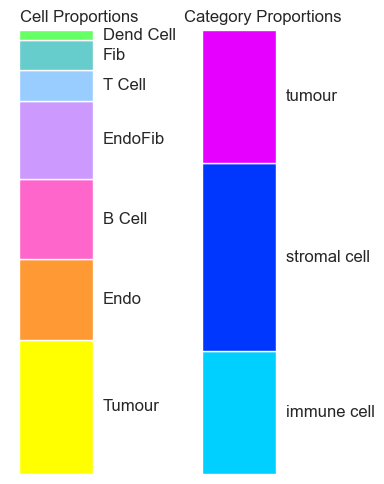

In [56]:
# Create colors for each cell type
colors = ['#FFFF00', '#FF9933', '#FF66CC', '#CC99FF', '#99CCFF', '#66CCCC', '#66FF66']
colors2 = ['#00d0ff', '#0037ff','#e600ff']
# Creation of a stacked bar chart, with two axes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 5), gridspec_kw={'width_ratios': [1, 1]})

# Graph 1 - cell_proportions
bottom = 0
for i, row in cell_proportionsEuMyc.iterrows():
    ax1.bar(0, row['phenotype'], bottom=bottom, color=colors[i], label=row['leiden_phenotype'])
    bottom += row['phenotype']

# Add cell labels on the right
y_pos = cell_proportionsEuMyc['phenotype'].cumsum() - (cell_proportionsEuMyc['phenotype'] / 2)
for i, cell_type in enumerate(cell_proportionsEuMyc['leiden_phenotype']):
    ax1.text(0.5, y_pos[i], cell_type, va='center', ha='left')
# Add a title to the first graph
ax1.set_title('Cell Proportions')
# Customizing axes for graph 1
ax1.set_xlim([-0.5, 1])
ax1.set_ylim([0, cell_proportionsEuMyc['phenotype'].sum()])
ax1.set_xticks([])
ax1.set_yticks([])

# Axles removed
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Graph 2 - category_proportions
bottom = 0  # Reset bottom variable
for i, row in category_proportionsEuMyc.iterrows():
    ax2.bar(0, row['phenotype'], bottom=bottom, color=colors2[i], label=row['category'])
    bottom += row['phenotype']

# Add category labels on the right
y_pos = category_proportionsEuMyc['phenotype'].cumsum() - (category_proportionsEuMyc['phenotype'] / 2)
for i, cell_type in enumerate(category_proportionsEuMyc['category']):
    ax2.text(0.5, y_pos[i], cell_type, va='center', ha='left')
# Add a title to the first graph
ax2.set_title('Category Proportions')
# Customizing axes for graph 2
ax2.set_xlim([-0.5, 1])
ax2.set_ylim([0, category_proportionsEuMyc['phenotype'].sum()])
ax2.set_xticks([])
ax2.set_yticks([])

# Axis removal
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Display graph
plt.tight_layout()
plt.show()


We assign spatial coordinates to the anndata object. We then calculate the distance between the cells before calculating the correlation.

In [57]:
adata_A20 = adata[adata.obs['model'] == 'A20'].copy()
# Assign spatial coordinates to AnnData object
adata_A20 = sm.tl.spatial_distance (adata, 
                               x_coordinate='X_centroid', y_coordinate='Y_centroid', 
                               z_coordinate=None, 
                               phenotype='leiden_phenotype', 
                               subset=None, 
                               imageid='imageid', 
                               label='spatial_distance')

df_A20 = adata_A20.uns['spatial_distance']
correlation_matrix_adata_A20 = df_A20.corr()

Processing Image: image


In [58]:
adata_EuMyc = adata[adata.obs['model'] == 'Eµ-Myc'].copy()
# Assign spatial coordinates to AnnData object
adata_EuMyc = sm.tl.spatial_distance (adata, 
                               x_coordinate='X_centroid', y_coordinate='Y_centroid', 
                               z_coordinate=None, 
                               phenotype='leiden_phenotype', 
                               subset=None, 
                               imageid='imageid', 
                               label='spatial_distance')

df_EuMyc = adata_EuMyc.uns['spatial_distance']
correlation_matrix_adata_EuMyc = df_EuMyc.corr()

Processing Image: image


## Figure 4F: We create a mask to hide the lower part of the heatmap

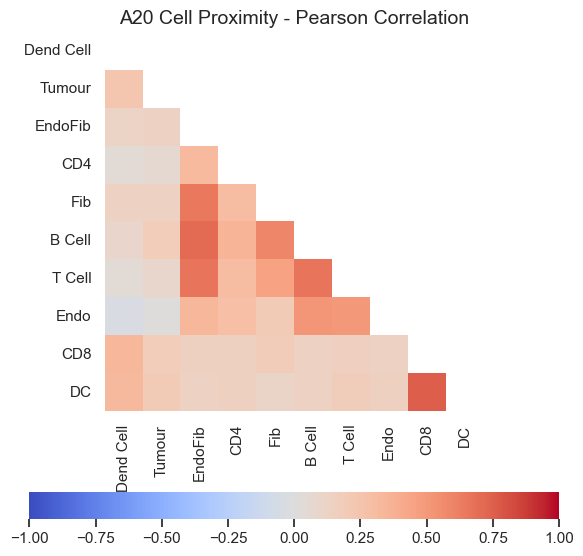

In [59]:
# Create a mask to display only the lower part of the triangle
mask = np.triu(np.ones_like(correlation_matrix_adata_A20, dtype=bool))

#Create heatmap with seaborn using mask
plt.figure(figsize=(6, 6))  # Adjust chart size to make it more compact
sns.heatmap(correlation_matrix_adata_A20, annot=False, cmap='coolwarm', vmin=-1, vmax=1, square=True, mask=mask, 
            xticklabels=correlation_matrix_adata_A20.columns, yticklabels=correlation_matrix_adata_A20.index, cbar_kws={"orientation": "horizontal"})

# Ajouter le titre
plt.title("A20 Cell Proximity - Pearson Correlation", fontsize=14)

# Ajuster l'affichage
plt.tight_layout()
plt.show()

## Figure 4I

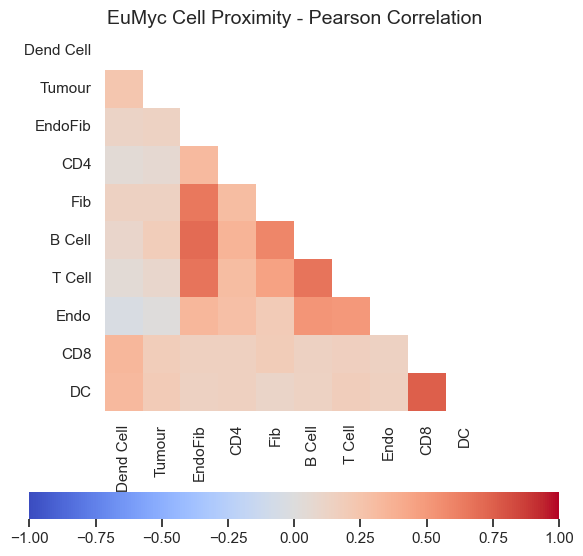

In [60]:
# Create a mask to display only the lower part of the triangle
mask = np.triu(np.ones_like(correlation_matrix_adata_EuMyc, dtype=bool))

# Create heatmap with seaborn using mask
plt.figure(figsize=(6, 6))  # Adjust chart size to make it more compact
sns.heatmap(correlation_matrix_adata_EuMyc, annot=False, cmap='coolwarm', vmin=-1, vmax=1, square=True, mask=mask, 
            xticklabels=correlation_matrix_adata_EuMyc.columns, yticklabels=correlation_matrix_adata_EuMyc.index, cbar_kws={"orientation": "horizontal"})

# Add title
plt.title("EuMyc Cell Proximity - Pearson Correlation", fontsize=14)

# Adjust display
plt.tight_layout()
plt.show()